In [ ]:
# import cmdstanpy
# cmdstanpy.install_cmdstan()
# from cmdstanpy import CmdStanModel

/media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/Final_work/thesis/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /home/brasammy/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# 1 . Data Generation with disease induced Deaths

## 1 . Define Parameters and Create initial values

In [5]:
n = 3  # Number of patches (Guinea, Liberia, Sierra Leone)
# N = np.array([12e6, 4.5e6, 6e6])  # Population per patch
N = np.array([2e6, 1.5e6, 1e6])

### 8·5 days (7·7–9·2) for the incubation period, 
### 9·3 days (8·5–10·1) for the symptom-onset-to-death delay,
### 13·0 days (10·4–15·7) for symptom-onset-to-recovery
### case fatality ratio for Guinea, Liberia, Sierra Leone 19–100%

sigma = 1/8.5 
gamma = 1/13 
alpha = 0.30  # Disease-induced death rate (30% CFR)

kappa = np.array([2.0, 1.5, 1.8])  # Contact rates
beta = np.array([0.3, 0.4, 0.35]) #[0.06, 0.07, 0.08])  # Transmission probabilities

## Travel and return rate
g = np.array([0.001, 0.001, 0.001])  # Travel rates
m = np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Travel fractions
r = np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Return rates

# Initial conditions
S0 = np.zeros((n, n))
E0 = np.zeros((n, n))
I0 = np.zeros((n, n))
R0 = np.zeros((n, n))
D0 = np.zeros((n, n))
C0 = np.zeros((n, n))


## loop and create some susceptible population with given rate
for i in range(n):
    S0[i, i] = N[i] * 0.99
    S0[i, (i+1)%n] = N[i] * 0.005
    S0[i, (i+2)%n] = N[i] * 0.005

# Initial infectives in Guinea
I0[0, 0] = 100
S0[0, 0] -= 100

# Initial infectives in Liberia
I0[1,1] = 10
S0[1,1] -= 10

# Initial infectives in Sierra Leone
I0[2,2] = 10
S0[2,2] -= 10

y0 = np.concatenate([S0.flatten(), E0.flatten(), I0.flatten(), R0.flatten(), D0.flatten(), C0.flatten()])

## 2 . Create the SEIRD Patch model

### simple model with Death compartment

---
### Residents of patch i currently in patch i

---

$$
\begin{aligned}
{S'}_{ii} &= -\sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} + \sum_{k=1}^n r_{ij} S_{ii} - g_i S_{ii} \\
{E'}_{ii} &= \sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} - \sigma E_{ii} + \sum_{k=1}^n r_{ij} E_{ii} - g_i E_{ii} \\
{I'}_{ii} &= \sigma E_{ii} - (\gamma + \alpha) I_{ii} + \sum_{k=1}^n r_{ij} I_{ii} - g_i I_{ii} \\
{R'}_{ii} &= \gamma I_{ii} + \sum_{k=1}^n r_{ij} R_{ii} - g_i R_{ii} \\
{D'}_{ii} &= \alpha I_{ii}
\end{aligned}
$$

---
### Residents of patch i currently in patch j

---
$$
\begin{aligned}
S'_{ij} &= -\sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} + g_i m_{ji}S_{ii} - r_{ij}S_{ij}\\
E'_{ij} &= \sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} - \sigma E_{ij} + g_i m_{ji}E_{ii} - r_{ij}E_{ij}\\
I'_{ij} &= \sigma E_{ij} - (\gamma + \alpha)I_{ij} + g_im_{ji}I_{ii} - r_{ij}I_{ij}\\
R'_{ij} &= \gamma I_{ij} + g_im_{ji}R_{ii} - r_{ij}R_{ij}\\
D'_{ij} &= \alpha I_{ij}
\end{aligned}
$$


- $S, E, I, R, D$: Susceptible, Exposed, Infectious, Recovered, and Dead compartments
- $\beta_{ik}$: Transmission rate from patch k to individuals in patch i
- $\sigma$: Rate at which exposed individuals become infectious (1/incubation period)
- $\gamma$: Recovery rate for infectious individuals
- $\alpha$: Disease-induced death rate
- $g_i$: Rate at which individuals leave patch i
- $r_{ij}$: Rate of return from patch j to patch i
- $m_{ji}$: fraction of individuals from patch i to patch j
- $k_j$: contact rate in patch j
- $N_j$: Total population in patch j

---
## Likelihoods
$$observed\_cases[t,p]∼ \text{NegativeBinomial}(ρ[p]×incidence[t,p],ϕ)$$

$$observed\_deaths[t,p]∼\text{NegativeBinomial}(ρ_d[p]×predicted\_deaths[t,p],ϕ_d)$$

Where:
- $\rho[p]$: Patch-specific reporting rate for cases
- $\rho_d[p]$: Patch-specific reporting rate for deaths
- $\phi$: Dispersion parameter for case counts
- $\phi_d$: Dispersion parameter for death counts



In [6]:
# Model equations
def model(y, t, n, N, sigma, gamma, alpha, kappa, beta, g, m, r):
    S = y[:n*n].reshape(n, n)
    E = y[n*n:2*n*n].reshape(n, n)
    I = y[2*n*n:3*n*n].reshape(n, n)
    R = y[3*n*n:4*n*n].reshape(n, n)
    D = y[4*n*n:5*n*n].reshape(n, n)
    C = y[5*n*n:].reshape(n, n)

    Np = np.sum(S + E + I + R, axis=0)  # Population in each patch (exclude D)
    dSdt = np.zeros((n, n))
    dEdt = np.zeros((n, n))
    dIdt = np.zeros((n, n))
    dRdt = np.zeros((n, n))
    dDdt = np.zeros((n, n))
    dCdt = np.zeros((n, n))

    for i in range(n):
        ## residents of Patch i who are currently in Patch j
        j = i
        foi_ii = sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

        ## calculate the change of each compartment
        dSdt[i, i] = sum(r[i, k] * S[i, k] for k in range(n)) - g[i] * S[i, i] - foi_ii
        dEdt[i, i] = sum(r[i, k] * E[i, k] for k in range(n)) - g[i] * E[i, i] + foi_ii - sigma * E[i, i]
        dIdt[i, i] = sum(r[i, k] * I[i, k] for k in range(n)) - g[i] * I[i, i] + sigma * E[i, i] - (gamma + alpha) * I[i, i]
        dRdt[i, i] = sum(r[i, k] * R[i, k] for k in range(n)) - g[i] * R[i, i] + gamma * I[i, i]
        dDdt[i, i] = alpha * I[i, i]
        dCdt[i, i] = sigma * E[i, i]

        ## residents of Patch i who are currently in Patch j
        for j in range(n):
            if j != i:
                foi = sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

                ## calculate the change of each compartment
                dSdt[i, j] = g[i] * m[j, i] * S[i, i] - r[i, j] * S[i, j] - foi
                dEdt[i, j] = g[i] * m[j, i] * E[i, i] - r[i, j] * E[i, j] + foi - sigma * E[i, j]
                dIdt[i, j] = g[i] * m[j, i] * I[i, i] - r[i, j] * I[i, j] + sigma * E[i, j] - (gamma + alpha) * I[i, j]
                dRdt[i, j] = g[i] * m[j, i] * R[i, i] - r[i, j] * R[i, j] + gamma * I[i, j]
                dDdt[i, j] = alpha * I[i, j]
                dCdt[i, j] = sigma * E[i, j]
                

    return np.concatenate([dSdt.flatten(), dEdt.flatten(), dIdt.flatten(), dRdt.flatten(), dDdt.flatten(), dCdt.flatten()])

## 3 . Solve the ODE and index the data

In [7]:

from scipy.integrate import odeint

# Solve ODE
T = 430
t = np.linspace(0, T, T)
sol = odeint(model, y0, t, args=(n, N, sigma, gamma, alpha, kappa, beta, g, m, r))

# Simulate SEIR for each region
# states = np.zeros((n, T, 5))
# incidence = np.zeros((n, T))

# Extract and aggregate results
S = sol[:, :n*n].reshape(-1, n, n)
E = sol[:, n*n:2*n*n].reshape(-1, n, n)
I = sol[:, 2*n*n:3*n*n].reshape(-1, n, n)
R = sol[:, 3*n*n:4*n*n].reshape(-1, n, n)
D = sol[:, 4*n*n:].reshape(-1, n, n)

## Total per patch (sum over resident patches i)
S_total = np.sum(S, axis=1)
E_total = np.sum(E, axis=1)
I_total = np.sum(I, axis=1)
R_total = np.sum(R, axis=1)
D_total = np.sum(D, axis=1)

In [8]:
S_total

array([[1992400.        , 1499990.        , 1007490.        ],
       [1994719.37802542, 1499984.84316541, 1005114.73362471],
       [1996116.36143878, 1499980.9636818 , 1003676.40562901],
       ...,
       [ 131295.68773864,   98625.42055425,   52732.26962624],
       [ 131295.66017393,   98625.27552396,   52732.26332065],
       [ 131295.63421884,   98625.13904248,   52732.2574116 ]],
      shape=(430, 3))

## 4 . Create dataframe for easy access

In [46]:
# Create dataset
data = {
    'Date': pd.date_range(start='2013-12-28', periods=T, freq='D'),
    'Day': t.astype(int),
    'S_Guinea': S_total[:, 0],
    'E_Guinea': E_total[:, 0],
    'I_Guinea': I_total[:, 0],
    'R_Guinea': R_total[:, 0],
    'D_Guinea': D_total[:, 0],

    'S_Liberia': S_total[:, 1],
    'E_Liberia': E_total[:, 1],
    'I_Liberia': I_total[:, 1],
    'R_Liberia': R_total[:, 1],
    'D_Liberia': D_total[:, 1],

    'S_SierraLeone': S_total[:, 2],
    'E_SierraLeone': E_total[:, 2],
    'I_SierraLeone': I_total[:, 2],
    'R_SierraLeone': R_total[:, 2],
    'D_SierraLeone': D_total[:, 2],

    'Travel_Rate_Guinea': np.full(T, g[0]),
    'Travel_Rate_Liberia': np.full(T, g[1]),
    'Travel_Rate_SierraLeone': np.full(T, g[2]),

    'Contact_Rate_Guinea': np.full(T, kappa[0]),
    'Contact_Rate_Liberia': np.full(T, kappa[1]),
    'Contact_Rate_SierraLeone': np.full(T, kappa[2])
}

df = pd.DataFrame(data)
df.to_csv('synthetic_ebola_dataset_with_death.csv', index=False)

## 5 . Plot the data infections for each patch

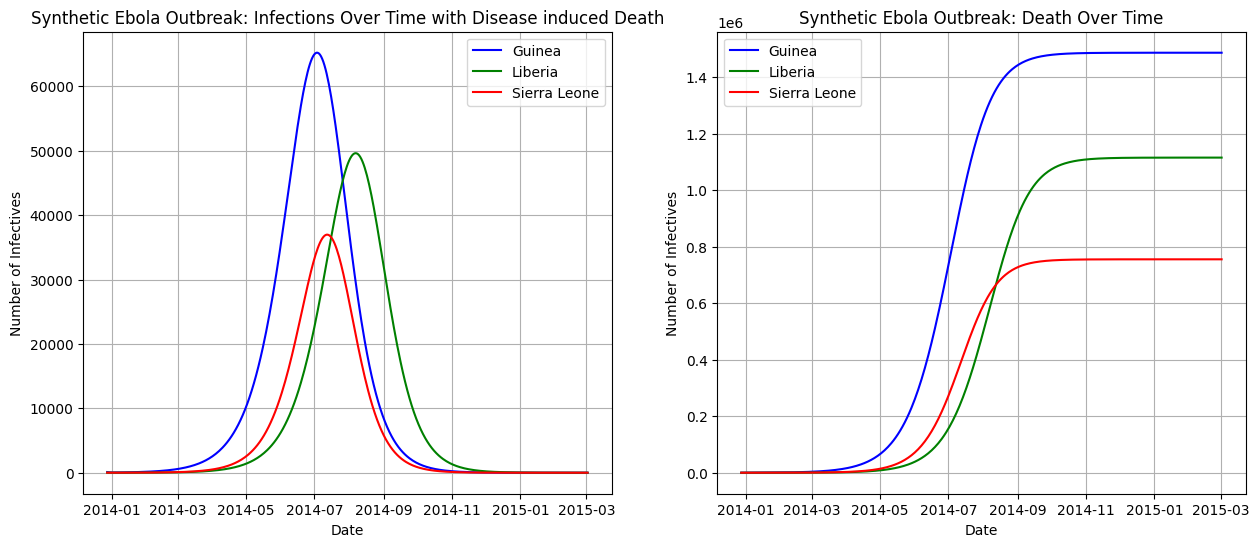

In [48]:
# Extract data for plotting
days = df['Date']
I_guinea = df['I_Guinea']
I_liberia = df['I_Liberia']
I_sierra_leone = df['I_SierraLeone']

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(days, I_guinea, label='Guinea', color='blue')
ax[0].plot(days, I_liberia, label='Liberia', color='green')
ax[0].plot(days, I_sierra_leone, label='Sierra Leone', color='red')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Infectives')
ax[0].set_title('Synthetic Ebola Outbreak: Infections Over Time with Disease induced Death')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(days, df['D_Guinea'], label='Guinea', color='blue')
ax[1].plot(days, df['D_Liberia'], label='Liberia', color='green')
ax[1].plot(days, df['D_SierraLeone'], label='Sierra Leone', color='red')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Infectives')
ax[1].set_title('Synthetic Ebola Outbreak: Death Over Time')
ax[1].legend()
ax[1].grid(True)

# Save and show the plot
# plt.savefig('ebola_infections_disease_death_plot.png')
plt.show()

### 6 . Define a function to plot the SEIRD Compartments

In [49]:
# Plot for each country
countries = ['Guinea', 'Liberia', 'SierraLeone']
def plot_SEIR(df, country_name, Death = False, save=False, yscale = True):
    # Extract data for the current country
    S = df[f'S_{country_name}']
    E = df[f'E_{country_name}']
    I = df[f'I_{country_name}']
    R = df[f'R_{country_name}']

    # Create plot
    plt.figure(figsize=(13, 6))
    plt.plot(df['Date'], S, label='Susceptible', color='blue')
    plt.plot(df['Date'], E, label='Exposed', color='orange')
    plt.plot(df['Date'], I, label='Infective', color='red')
    plt.plot(df['Date'], R, label='Recovered', color='green')
    if Death:
        D = df[f'D_{country_name}']
        plt.plot(df['Date'], D, label='Death', color='black')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Number of Individuals')
    plt.title(f'SEIRD Dynamics for {country_name}')
    plt.legend()
    plt.grid(True)
    if yscale:
        plt.yscale('symlog')  # Use symlog scale to handle large ranges
    if save:
        plt.savefig(f'seird_{country_name.lower()}.png')
    plt.show()

In [51]:
# plot_SEIR(df, 'Guinea', Death=True)

In [14]:
# plot_SEIR(df, 'Liberia', Death=True)

In [15]:
# plot_SEIR(df, 'SierraLeone', Death=True)

In [16]:
# Load the synthetic dataset
# df = pd.read_csv('synthetic_ebola_dataset_with_death.csv')

# Prepare data for Stan
P = 3
T = len(df)
t0 = -1
ts = df['Day'].values
I_obs = df[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values
D_obs = df[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values.astype(int)
N = np.array([12e6, 4.5e6, 6e6]).astype(int)
E0 = np.array([0, 0, 0])
I0 = np.array([100, 10, 10])

stan_data = {
    'P': P,
    'T': T,
    't0': t0,
    'ts': ts,
    'cases': I_obs.astype(int),
    'deaths': D_obs.astype(int),
    'N': N,
    'E0': E0,
    'I0': I0,
    'sigma':sigma,
    'gamma': gamma,
    'alpha': alpha
}

In [17]:
stan_data['cases']

array([[100,  10,  10],
       [ 71,   7,   7],
       [ 55,   5,   5],
       ...,
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], shape=(1000, 3))

In [ ]:
# Compile and run the Stan model
model = CmdStanModel(stan_file='multi_patch.stan')
fit = model.sample(data=stan_data,
                   chains=4,
                   iter_warmup=100,
                   iter_sampling=100)

$$incidence_i = \sigma × (E_{ii} + \sum_{j\neq i} E_{ji})$$

In [ ]:
print(fit.diagnose())

Checking sampler transitions treedepth.
400 of 100 (400.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.02, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  predicted_cases[2,1], predicted_cases[3,1], predicted_cases[4,1], predicted_cases[5,1], predicted_cases[6,1], predicted_cases[7,1], predicted_cases[8,1], predicted_cases[9,1], predicted_cases[10,1], predicted_cases[11,1], predicted_cases[12,1], p

In [ ]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-3.777510e+10,NaN,4.151230e+10,3.681930e+10,-1.004140e+11,-2.517510e+10,-3.362960e+08,NaN,NaN,NaN
beta[1],1.836890e+00,NaN,1.184340e+00,1.408140e+00,4.541670e-01,1.695070e+00,3.503270e+00,NaN,NaN,NaN
beta[2],6.275700e-01,NaN,3.199810e-01,3.506340e-01,1.772810e-01,6.925300e-01,9.479380e-01,NaN,NaN,NaN
beta[3],1.345950e+00,NaN,1.446600e+00,5.784830e-01,1.507670e-01,7.154360e-01,3.802170e+00,NaN,NaN,NaN
phi_inv,3.854550e+00,NaN,2.096970e+00,7.952150e-01,2.931060e-01,4.822640e+00,5.479840e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
"predicted_cases[999,2]",2.000000e-02,NaN,1.862440e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
"predicted_cases[999,3]",2.500000e-03,NaN,5.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
"predicted_cases[1000,1]",6.182500e+00,NaN,2.842250e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.805000e+01,NaN,NaN,NaN
"predicted_cases[1000,2]",1.150000e-01,NaN,6.463900e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02,NaN,NaN,NaN


# 2 . Without Disease induced Deaths

### simple model without Death compartment

---
### Residents of patch i currently in patch i

---

$$
\begin{aligned}
{S'}_{ii} &= -\sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} + \sum_{k=1}^n r_{ij} S_{ii} - g_i S_{ii} \\
{E'}_{ii} &= \sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} - \sigma E_{ii} + \sum_{k=1}^n r_{ij} E_{ii} - g_i E_{ii} \\
{I'}_{ii} &= \sigma E_{ii} - \gamma I_{ii} + \sum_{k=1}^n r_{ij} I_{ii} - g_i I_{ii} \\
{R'}_{ii} &= \gamma I_{ii} + \sum_{k=1}^n r_{ij} R_{ii} - g_i R_{ii}
\end{aligned}
$$

---
### Residents of patch i currently in patch j

---
$$
\begin{aligned}
S'_{ij} &= -\sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} + g_i m_{ji}S_{ii} - r_{ij}S_{ij}\\
E'_{ij} &= \sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} - \sigma E_{ij} + g_i m_{ji}E_{ii} - r_{ij}E_{ij}\\
I'_{ij} &= \sigma E_{ij} - \gamma I_{ij} + g_im_{ji}I_{ii} - r_{ij}I_{ij}\\
R'_{ij} &= \gamma I_{ij} + g_im_{ji}R_{ii} - r_{ij}R_{ij}
\end{aligned}
$$


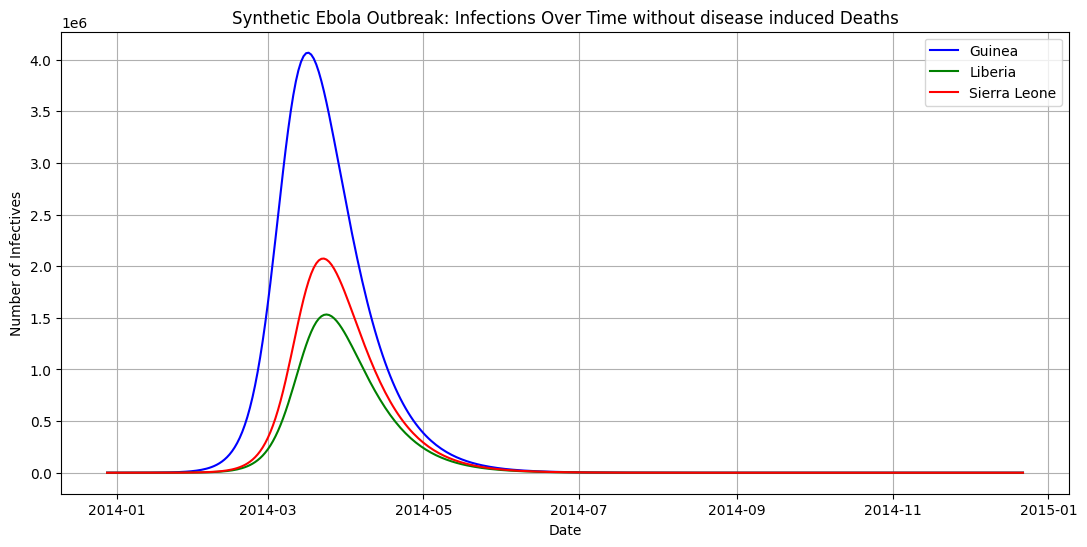

In [22]:
n = 3
 ## Population per patch (Guinea, Liberia, Sierra Leone)
N = np.array([12e6, 4.5e6, 6e6])

### 8·5 days (7·7–9·2) for the incubation period, 
### 9·3 days (8·5–10·1) for the symptom-onset-to-death delay,
### 13·0 days (10·4–15·7) for symptom-onset-to-recovery

sigma = 1/8.5  # Latent period (~7 days)
gamma = 1/13  # Recovery rate (~10 days)
kappa = np.array([2.0, 1.5, 1.8])  # Contact rates
beta = np.array([0.3, 0.4, 0.35]) #[0.06, 0.07, 0.08])  # Transmission probabilities

## Travel and return rate
g = np.array([0.001, 0.001, 0.001])  # Travel rates
m = np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Travel fractions
r = np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Return rates

# Initial conditions: Small outbreak in Guinea
S01 = np.zeros((n, n))
E01 = np.zeros((n, n))
I01 = np.zeros((n, n))
R01 = np.zeros((n, n))

## get the number of individuals currently in the patches and those traveled
for i in range(n):
    S01[i, i] = N[i] * 0.99
    S01[i, (i+1)%n] = N[i] * 0.005
    S01[i, (i+2)%n] = N[i] * 0.005

# Initial infectives in Guinea
I01[0, 0] = 100
S01[0, 0] -= 100

# Initial infectives in Liberia
I01[1,1] = 10
S01[1,1] -= 10

# Initial infectives in Sierra Leone
I01[2,2] = 10
S01[2,2] -= 10

y01 = np.concatenate([S01.flatten(), E01.flatten(), I01.flatten(), R01.flatten()])

# Model equations
def model1(y, t, n, N, sigma, gamma, kappa, beta, g, m, r):
    S = y[:n*n].reshape(n, n)
    E = y[n*n:2*n*n].reshape(n, n)
    I = y[2*n*n:3*n*n].reshape(n, n)
    R = y[3*n*n:].reshape(n, n)

    Np = np.sum(S + E + I + R, axis=0)  # Population in each patch
    dSdt = np.zeros((n, n))
    dEdt = np.zeros((n, n))
    dIdt = np.zeros((n, n))
    dRdt = np.zeros((n, n))

    for i in range(n):
        ## Calculate ds_dt for the Residents of Patch i currently in Patch i
        j = i

        ## create the force infection
        foi = sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

        ## calculate the change in the compartments
        dSdt[i, i] = - foi + sum(r[i, k] * S[i, k] for k in range(n)) - g[i] * S[i, i]
        dEdt[i, i] = foi - sigma * E[i, i] + sum(r[i, k] * E[i, k] for k in range(n)) - g[i] * E[i, i]
        dIdt[i, i] = sigma * E[i, i] - gamma * I[i, i] + sum(r[i, k] * I[i, k] for k in range(n)) - g[i] * I[i, i]
        dRdt[i, i] = gamma * I[i, i] + sum(r[i, k] * R[i, k] for k in range(n)) - g[i] * R[i, i]

        ## Calculate ds_dt for the Residents of Patch i currently in Patch j
        for j in range(n):
            if j != i:
                ## create force of infection
                foi = sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

                ## calculate the change in the compartments
                dSdt[i, j] =  - foi + g[i] * m[j, i] * S[i, i] - r[i, j] * S[i, j]
                dEdt[i, j] = foi - sigma * E[i, j] + g[i] * m[j, i] * E[i, i] - r[i, j] * E[i, j]
                dIdt[i, j] = sigma * E[i, j] - gamma * I[i, j] + g[i] * m[j, i] * I[i, i] - r[i, j] * I[i, j]
                dRdt[i, j] = gamma * I[i, j] + g[i] * m[j, i] * R[i, i] - r[i, j] * R[i, j]

    return np.concatenate([dSdt.flatten(), dEdt.flatten(), dIdt.flatten(), dRdt.flatten()])


T=360
## Solve ODE
t = np.linspace(0, T, T)
sol1 = odeint(model1, y01, t, args=(n, N, sigma, gamma, kappa, beta, g, m, r))

## Extract and aggregate results
S1 = sol1[:, :n*n].reshape(-1, n, n)
E1 = sol1[:, n*n:2*n*n].reshape(-1, n, n)
I1 = sol1[:, 2*n*n:3*n*n].reshape(-1, n, n)
R1 = sol1[:, 3*n*n:].reshape(-1, n, n)

## Total per patch (sum over resident patches i)
S_total1 = np.sum(S1, axis=1)
E_total1 = np.sum(E1, axis=1)
I_total1 = np.sum(I1, axis=1)
R_total1 = np.sum(R1, axis=1)

## Create dataset with time, totals per patch, and parameters
data1= {
    'Date': pd.date_range(start='2013-12-28', periods=T, freq='D'),
    'Day': t.astype(int),
    'S_Guinea': S_total1[:, 0],
    'E_Guinea': E_total1[:, 0],
    'I_Guinea': I_total1[:, 0],
    'R_Guinea': R_total1[:, 0],

    'S_Liberia': S_total1[:, 1],
    'E_Liberia': E_total1[:, 1],
    'I_Liberia': I_total1[:, 1],
    'R_Liberia': R_total1[:, 1],

    'S_SierraLeone': S_total1[:, 2],
    'E_SierraLeone': E_total1[:, 2],
    'I_SierraLeone': I_total1[:, 2],
    'R_SierraLeone': R_total1[:, 2],
    
    'Travel_Rate_Guinea': np.full(T, g[0]),
    'Travel_Rate_Liberia': np.full(T, g[1]),
    'Travel_Rate_SierraLeone': np.full(T, g[2]),
    'Contact_Rate_Guinea': np.full(T, kappa[0]),
    'Contact_Rate_Liberia': np.full(T, kappa[1]),
    'Contact_Rate_SierraLeone': np.full(T, kappa[2])
}

## Convert to a dataframe
df1 = pd.DataFrame(data1)
df.to_csv('synthetic_nodeath.csv', index=False)
# print("Synthetic dataset saved as 'synthetic_ebola_dataset.csv'")

## Extract data for plotting
days = df1['Date']
I_guinea1 = df1['I_Guinea']
I_liberia1 = df1['I_Liberia']
I_sierra_leone1 = df1['I_SierraLeone']

## Create the plot
plt.figure(figsize=(13, 6))
plt.plot(days, I_guinea1, label='Guinea', color='blue')
plt.plot(days, I_liberia1, label='Liberia', color='green')
plt.plot(days, I_sierra_leone1, label='Sierra Leone', color='red')

## Customize the plot
plt.xlabel('Date')
plt.ylabel('Number of Infectives')
plt.title('Synthetic Ebola Outbreak: Infections Over Time without disease induced Deaths')
plt.legend()
plt.grid(True)

## Save and show the plot
# plt.savefig('ebola_infections_plot.png')
plt.show()

In [128]:
df1

,Date,Day,S_Guinea,E_Guinea,I_Guinea,R_Guinea,S_Liberia,E_Liberia,I_Liberia,R_Liberia,S_SierraLeone,E_SierraLeone,I_SierraLeone,R_SierraLeone,Travel_Rate_Guinea,Travel_Rate_Liberia,Travel_Rate_SierraLeone,Contact_Rate_Guinea,Contact_Rate_Liberia,Contact_Rate_SierraLeone
0,2013-12-28,0,1.193240e+07,0.000000,100.000000,0.000000e+00,4.544990e+06,0.000000,10.000000,0.000000e+00,6.022490e+06,0.000000,10.000000,0.000000e+00,0.001,0.001,0.001,2.0,1.5,1.8
1,2013-12-29,1,1.195368e+07,55.162572,95.766913,7.503916e+00,4.530760e+06,5.546914,9.618014,7.536030e-01,6.015372e+06,5.841703,9.635611,7.540678e-01,0.001,0.001,0.001,2.0,1.5,1.8
2,2013-12-30,2,1.196653e+07,103.584756,97.703869,1.492517e+01,4.522147e+06,10.456218,9.840961,1.502936e+00,6.011062e+06,11.044984,9.909940,1.506631e+00,0.001,0.001,0.001,2.0,1.5,1.8
3,2013-12-31,3,1.197428e+07,149.231014,104.813063,2.269957e+01,4.516933e+06,15.106334,10.580667,2.289965e+00,6.008452e+06,16.012353,10.733253,2.302270e+00,0.001,0.001,0.001,2.0,1.5,1.8
4,2014-01-01,4,1.197894e+07,195.184639,116.573478,3.120400e+01,4.513775e+06,19.801370,11.790602,3.152203e+00,6.006869e+06,21.075088,12.060065,3.181008e+00,0.001,0.001,0.001,2.0,1.5,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2014-12-18,355,4.925087e+03,0.000056,0.009353,1.198160e+07,1.853212e+03,0.000036,0.006113,4.507129e+06,1.673820e+03,0.000030,0.007007,6.002817e+06,0.001,0.001,0.001,2.0,1.5,1.8
356,2014-12-19,356,4.925087e+03,0.000052,0.008664,1.198160e+07,1.853212e+03,0.000034,0.005663,4.507129e+06,1.673820e+03,0.000028,0.006490,6.002817e+06,0.001,0.001,0.001,2.0,1.5,1.8
357,2014-12-20,357,4.925087e+03,0.000048,0.008027,1.198160e+07,1.853212e+03,0.000031,0.005246,4.507129e+06,1.673820e+03,0.000026,0.006011,6.002817e+06,0.001,0.001,0.001,2.0,1.5,1.8
358,2014-12-21,358,4.925087e+03,0.000044,0.007436,1.198160e+07,1.853212e+03,0.000029,0.004860,4.507129e+06,1.673820e+03,0.000024,0.005568,6.002817e+06,0.001,0.001,0.001,2.0,1.5,1.8


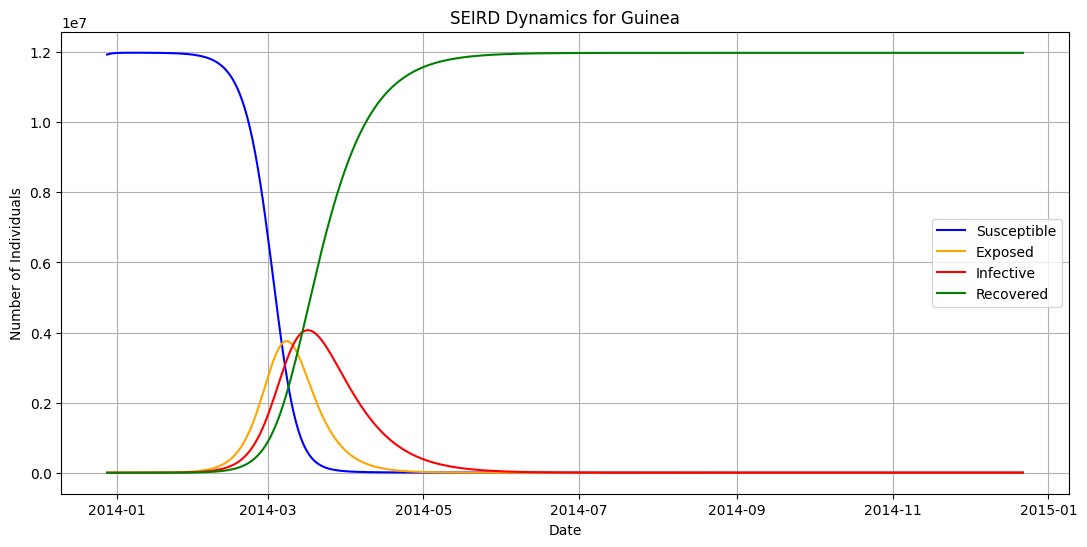

In [129]:
plot_SEIR(df1, 'Guinea', yscale=False)

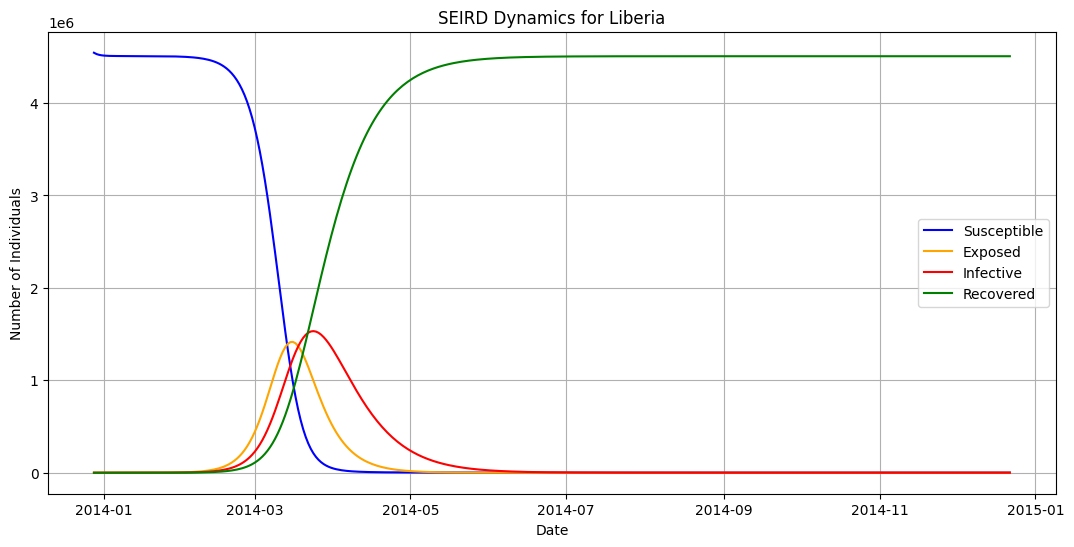

In [130]:
plot_SEIR(df1, 'Liberia', yscale=False)

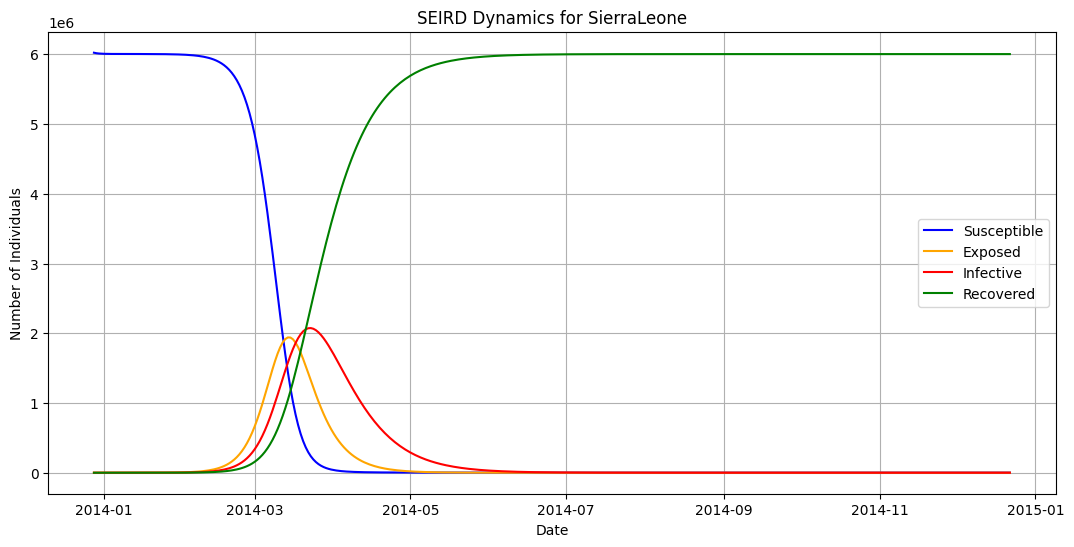

In [131]:
plot_SEIR(df1, 'SierraLeone', yscale=False)

In [122]:
# Load the synthetic dataset
df = pd.read_csv('synthetic_ebola_dataset_with_death.csv')

# Prepare data for Stan
P = 3
T = len(df)
t0 = -1
ts = df['Day'].values
I_obs = df[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values.astype(int)
D_obs = df[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values.astype(int)
N = np.array([12e6, 4.5e6, 6e6])
E0 = np.array([0, 0, 0])
I0 = np.array([100, 0, 0])

stan_data = {
    'P': P,
    'T': T,
    't0': t0,
    'ts': ts,
    'I_obs': I_obs,
    'D_obs': D_obs,
    'N': N,
    'E0': E0,
    'I0': I0
}

In [ ]:
# Compile and run the Stan model
model = CmdStanModel(stan_file='coupling.stan')
fit = model.sample(data=stan_data,
                   chains=4,
                   parallel_chains=4,
                   iter_warmup=10,
                   iter_sampling=10)

ValueError: no such file /var/autofs/misc/home/samuela/Documents/thesis/myvenv/thesis/coupling.stan

In [ ]:
# Summarize results
print(fit.summary())
fit.save_csvfiles('stan_output_seird')
print("Stan output saved in 'stan_output_seird' directory")